In [1]:
import pandas as pd

<h1> Load Dataset </h1>

In [2]:
## CSV from: https://www.kaggle.com/code/salikhussaini49/read-data-from-directory
df = pd.read_csv('data/dataset.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


<h1> Pre-processing </h1>

In [4]:
"""Méthode qui permet de fill les NaN avec une méthode qui s'appel le ForwardFill
et qui fait aussi du Backward fill"""

def impute_missing_vals(df, attributes):
    df_clean = df.copy()
    for att in attributes:
        if df_clean[att].isnull().sum() == len(df_clean):
            df_clean[att] = df_clean[att].fillna(0) # On remplie les cases par des 0
        elif df_clean[att].isnull().sum() == len(df_clean) - 1:
            df_clean[att] = df_clean[att].ffill().bfill() # On remplie les cases à l'aide d'un Forward Fill et d'un Backward Fill
        else:
            df_clean[att] = df_clean[att].interpolate(method='nearest', limit_direction='both') # On utilise une méthode d'interpolation pour remplir avec des valeurs non nulles.
            df_clean[att] = df_clean[att].ffill().bfill()
    
    return df_clean

In [5]:
df = impute_missing_vals(df, df.columns)

In [6]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(df.loc[:, df.columns != 'Patient_ID'].to_numpy())
df.loc[:, df.columns != 'Patient_ID'] = scaled_data

In [7]:
df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0.000000,0.173077,1.0,0.51134,0.389286,0.185714,0.175,0.156566,0.266667,0.287879,...,0.395133,0.141749,0.634186,0.0,1.0,0.0,0.995546,0.000000,0.0,17072
1,0.002985,0.173077,1.0,0.51134,0.389286,0.185714,0.175,0.156566,0.266667,0.287879,...,0.395133,0.141749,0.634186,0.0,1.0,0.0,0.995546,0.002985,0.0,17072
2,0.005970,0.223077,1.0,0.51134,0.389286,0.080357,0.175,0.156566,0.266667,0.287879,...,0.395133,0.141749,0.634186,0.0,1.0,0.0,0.995546,0.005970,0.0,17072
3,0.008955,0.203846,1.0,0.51134,0.389286,0.080357,0.175,0.161616,0.266667,0.287879,...,0.395133,0.141749,0.634186,0.0,1.0,0.0,0.995546,0.008955,0.0,17072
4,0.011940,0.192308,1.0,0.51134,0.389286,0.192857,0.175,0.131313,0.266667,0.287879,...,0.395133,0.141749,0.634186,0.0,1.0,0.0,0.995546,0.011940,0.0,17072


<h1> Transformer </h1>

In [8]:
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
 
  def __init__(self, x, y): 
    self.x_train = torch.tensor(x,dtype=torch.float32)
    self.y_train = torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [9]:
x = df.iloc[:,df.columns != 'SepsisLabel'].values
y = df['SepsisLabel'].values

dataset = MyDataset(x, y)

In [80]:
batch_size=16

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
#test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, num_workers=2)

In [81]:
img_batch, _ = next(iter(train_loader))
print(img_batch.min(), img_batch.max())

tensor(0.) tensor(17072.)


In [109]:
def get_data(batch_size, input_sequence_length, output_sequence_length):
    i = input_sequence_length + output_sequence_length
    
    t = torch.zeros(batch_size,1).uniform_(0,44 - i).int()
    b = torch.arange(-10, -10 + i).unsqueeze(0).repeat(batch_size, 1) + t
    
    s = torch.sigmoid(b.float())
    return s[:, :input_sequence_length].unsqueeze(-1), s[:,-output_sequence_length:]

In [112]:
X, Y = get_data(16, 42, 1)

In [113]:
X

tensor([[[4.5398e-05],
         [1.2339e-04],
         [3.3535e-04],
         [9.1105e-04],
         [2.4726e-03],
         [6.6929e-03],
         [1.7986e-02],
         [4.7426e-02],
         [1.1920e-01],
         [2.6894e-01],
         [5.0000e-01],
         [7.3106e-01],
         [8.8080e-01],
         [9.5257e-01],
         [9.8201e-01],
         [9.9331e-01],
         [9.9753e-01],
         [9.9909e-01],
         [9.9966e-01],
         [9.9988e-01],
         [9.9995e-01],
         [9.9998e-01],
         [9.9999e-01],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00],
         [1.0000e+00]],

        [[4.5398e-05],
         

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils import *
from Network import *

%matplotlib notebook
import matplotlib.pyplot as plt

#hyperparams
enc_seq_len = 6 # length of input given to encoder. Can have any integer value.
dec_seq_len = 2 # length of input given to decoder. Can have any integer value.
output_sequence_length = 1 # Length of the target sequence, i.e. how many time steps should your forecast cover

input_size = 42 # The number of input variables. 1 if univariate forecasting.
dim_val = 16 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
dim_attn = 8
lr = 0.002
epochs = 20

n_heads = 3 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number

n_decoder_layers = 3
n_encoder_layers = 3

batch_size = 13

#init network and optimizer
t = Transformer(dim_val, dim_attn, input_size, dec_seq_len, output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads)
optimizer = torch.optim.Adam(t.parameters(), lr=lr)

#keep track of loss for graph
losses = []

<IPython.core.display.Javascript object>


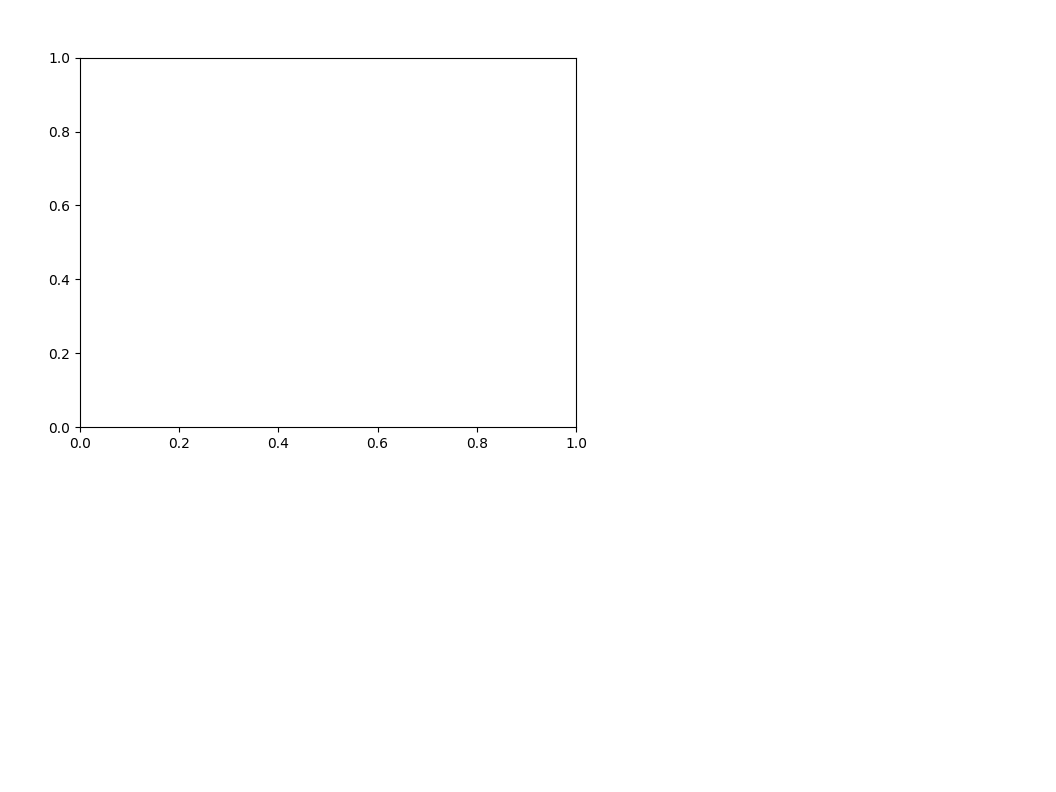

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [86]:
#build live matplotlib fig
fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

    
for e in range(epochs):
    out = []
    
    #for b in range(-10- enc_seq_len, 10 - enc_seq_len):
    for b in train_loader:
        optimizer.zero_grad()
        #X, Y = get_data(batch_size, enc_seq_len, output_sequence_length)
        X, Y = b
        
        #Forward pass and calculate loss
        net_out = t(X)
        #print(net_out.shape,Y.shape)
        loss = torch.mean((net_out - Y) ** 2)

        #backwards pass
        loss.backward()
        optimizer.step()

        #Track losses and draw rgaph
        out.append([net_out.detach().numpy(), Y])
        losses.append(loss)

        ax.clear()
        ax.plot(losses)
        ax.set_title("Mean Squared Error")
        fig.canvas.draw()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

o = []
x = [torch.sigmoid(torch.arange(-10,-1).float()).unsqueeze(-1).numpy().tolist()]

#Draw graph comparing to sigmoid
for i in range(-10, 10, output_sequence_length):
    o.append([torch.sigmoid(torch.tensor(i).float())])
    q = torch.tensor(x).float()
    
    if(output_sequence_length == 1):
        x[0].append([t(q).detach().squeeze().numpy()])
    else:
        for a in t(q).detach().squeeze().numpy():
            x[0].append([a])
            
ax.clear()
ax.plot(x[0], label='Network output')
ax.plot(o, label='Sigmoid function')
ax.set_title("")
ax.legend(loc='upper left', frameon=False)